 <span style="font-size:28px;"> **SKIN LESION CLASSIFICATION - DENSENET-201 + IMAGEDATAGENERATOR AND STORAGE.** </span>


The HAM10000 dataset has 7 different classes of skin lesion which are listed below :
1. Melanocytic nevi
2. Melanoma
3. Benign keratosis-like lesions
4. Basal cell carcinoma
5. Actinic keratoses
6. Vascular lesions
7. Dermatofibroma

 <span style="font-size:28px;"> **Importing and Installing Essential Libraries.** </span>

In [2]:
from numpy.random import seed
seed(101)
import tensorflow as tf
tf.random.set_seed(101)

import tensorflowjs as tfjs
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten


import pandas as pd
import numpy as np
#import keras
#from keras import backend as K

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

# Directory Structure

We create folders to store images that will later be fed to Keras generators

In [19]:
base_dir = 'base_dir'
os.mkdir(base_dir)

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)


# create new folders inside test_dir
nv = os.path.join(test_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(test_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(test_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(test_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(test_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(test_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(test_dir, 'df')
os.mkdir(df)

In [3]:
df_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df_data.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
#X = df_data.drop('dx', axis=1)
y = df_data['dx']

df_train, df_test = train_test_split(df_data, test_size=0.1, random_state=42, stratify=y)

print(df_train.shape)
print(df_test.shape)

(9013, 7)
(1002, 7)


In [5]:
y = df_train['dx']

df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42, stratify=y)

print(df_train.shape)
print(df_val.shape)

(8111, 7)
(902, 7)


In [6]:
#How many image each class in train set?
df_train['dx'].value_counts()

dx
nv       5430
mel       902
bkl       890
bcc       417
akiec     264
vasc      115
df         93
Name: count, dtype: int64

In [7]:
#How many image each class in val set?
df_val['dx'].value_counts()

dx
nv       604
mel      100
bkl       99
bcc       46
akiec     30
vasc      13
df        10
Name: count, dtype: int64

In [8]:
#How many image each class in test set?
df_test['dx'].value_counts()

dx
nv       671
mel      111
bkl      110
bcc       51
akiec     33
vasc      14
df        12
Name: count, dtype: int64

# Now we will transfer the images into the created subfolders

In [9]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True, drop=False)
df_data

,lesion_id,image_id,dx,dx_type,age,sex,localization
image_id,,,,,,,
ISIC_0027419,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
ISIC_0025030,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
ISIC_0026769,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
ISIC_0025661,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
ISIC_0031633,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
ISIC_0033084,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
ISIC_0033550,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
ISIC_0033536,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen


In [20]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('../input/skin-cancer-mnist-ham10000/ham10000_images_part_1')
folder_2 = os.listdir('../input/skin-cancer-mnist-ham10000/ham10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])
test_list = list(df_test['image_id'])


# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/skin-cancer-mnist-ham10000/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/skin-cancer-mnist-ham10000/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/skin-cancer-mnist-ham10000/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/skin-cancer-mnist-ham10000/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        
        
for image in test_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image, 'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/skin-cancer-mnist-ham10000/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(test_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/skin-cancer-mnist-ham10000/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(test_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [21]:
# check how many train images we have in each train folder

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5430
902
890
417
264
115
93


In [22]:
# check how many val images we have in each val folder

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

604
100
99
46
30
13
10


In [23]:
# check how many val images we have in each test folder

print(len(os.listdir('base_dir/test_dir/nv')))
print(len(os.listdir('base_dir/test_dir/mel')))
print(len(os.listdir('base_dir/test_dir/bkl')))
print(len(os.listdir('base_dir/test_dir/bcc')))
print(len(os.listdir('base_dir/test_dir/akiec')))
print(len(os.listdir('base_dir/test_dir/vasc')))
print(len(os.listdir('base_dir/test_dir/df')))

671
111
110
51
33
14
12


# IMAGEDATAGENERATOR AND STORAGE

**Augmentation Train Set**

In [24]:
class_list = ['mel','bkl','bcc','akiec','vasc','nv','df']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 8000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 902 images belonging to 1 classes.
Found 890 images belonging to 1 classes.
Found 417 images belonging to 1 classes.
Found 264 images belonging to 1 classes.
Found 115 images belonging to 1 classes.
Found 5430 images belonging to 1 classes.
Found 93 images belonging to 1 classes.


In [25]:
# check how many train images we have in each train folder

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

8030
7666
7970
7489
7114
6195
7490


**Augmentation Val Set**

In [26]:
class_list = ['mel','bkl','bcc','akiec','vasc','nv','df']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/val_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/val_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/val_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 10

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 1000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 100 images belonging to 1 classes.
Found 99 images belonging to 1 classes.
Found 46 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 13 images belonging to 1 classes.
Found 604 images belonging to 1 classes.
Found 10 images belonging to 1 classes.


In [27]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

1004
1000
1000
930
1000
660
1000


In [10]:
def get_num_files(path):
    total_files = 0
    for root, dirs, files in os.walk(path):
        total_files += len(files)
    return total_files

In [11]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = 'base_dir/test_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 4
image_size = 224

train_steps = np.ceil(get_num_files(train_path) / train_batch_size)
val_steps = np.ceil(get_num_files(valid_path) / val_batch_size)

In [12]:
datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.densenet.preprocess_input,
)

train_batches = datagen.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=train_batch_size
)

valid_batches = datagen.flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size
)

test_batches = datagen.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=1,
    shuffle=False
)

Found 51954 images belonging to 7 classes.
Found 6594 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


# MODEL SET UP

In [13]:
from tensorflow.keras.applications.densenet import DenseNet201
pre_trained_model = DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

74836368/74836368 [==============================] - 0s 0us/step


In [14]:
pre_trained_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

In [15]:
last_layer = pre_trained_model.get_layer('relu')
print('Last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

Last layer output shape: (None, 7, 7, 1920)


In [16]:
# Flatten the output layer to 1 dimension
x = GlobalAveragePooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = Dropout(0.3)(x)
# Add a final sigmoid layer for classification
x = Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
filepath = "model.h5" #use recall
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose = 1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.0000001)

Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=30, min_delta=0.001)
callbacks_list = [checkpoint, reduce_lr, Earlystop]

history = model.fit(train_batches, steps_per_epoch=train_steps,
                    #class_weight=normalized_class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=200, verbose=1,
                   callbacks=callbacks_list
                   )

Epoch 1/200
1624/1624 [==============================] - ETA: 0s - loss: 0.4759 - accuracy: 0.8234
Epoch 1: val_accuracy improved from -inf to 0.75796, saving model to model.h5
1624/1624 [==============================] - 510s 314ms/step - loss: 0.4759 - accuracy: 0.8234 - val_loss: 0.7069 - val_accuracy: 0.7580 - lr: 0.0010
Epoch 2/200
1624/1624 [==============================] - ETA: 0s - loss: 0.3674 - accuracy: 0.8641
Epoch 2: val_accuracy improved from 0.75796 to 0.80467, saving model to model.h5
1624/1624 [==============================] - 511s 315ms/step - loss: 0.3674 - accuracy: 0.8641 - val_loss: 0.5945 - val_accuracy: 0.8047 - lr: 0.0010
Epoch 3/200
1624/1624 [==============================] - ETA: 0s - loss: 0.2957 - accuracy: 0.8916
Epoch 3: val_accuracy did not improve from 0.80467
1624/1624 [==============================] - 509s 313ms/step - loss: 0.2957 - accuracy: 0.8916 - val_loss: 1.2218 - val_accuracy: 0.6990 - lr: 0.0010
Epoch 4/200
1624/1624 [====================

# MODEL EVALUATION

In [19]:
test_labels = test_batches.classes
test_labels.shape

(1002,)

In [21]:
model.load_weights('model.h5')
# make a prediction
predictions = model.predict(test_batches, steps=len(df_test), verbose=1)

1002/1002 [==============================] - 161s 160ms/step


In [22]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [24]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[ 22   2   3   0   4   2   0]
 [  1  38   4   1   1   6   0]
 [  3   3  75   0   4  25   0]
 [  0   0   0  10   0   2   0]
 [  2   1   8   0  53  47   0]
 [  1   2   6   0  12 648   2]
 [  0   0   0   0   0   1  13]]


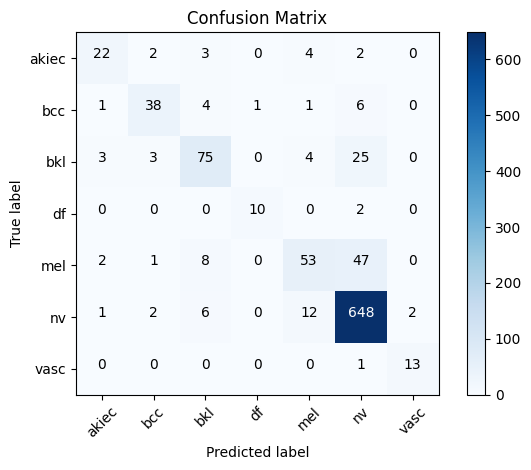

In [25]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [26]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [27]:
# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.76      0.67      0.71        33
         bcc       0.83      0.75      0.78        51
         bkl       0.78      0.68      0.73       110
          df       0.91      0.83      0.87        12
         mel       0.72      0.48      0.57       111
          nv       0.89      0.97      0.92       671
        vasc       0.87      0.93      0.90        14

    accuracy                           0.86      1002
   macro avg       0.82      0.76      0.78      1002
weighted avg       0.85      0.86      0.85      1002

